In [1]:
import cv2
from functools import partial
import flow_vis
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import color, img_as_float32
from skimage.transform import pyramid_reduce, resize,warp

In [2]:
def resize_flow_vectors(u, v, lvl):
    r, c = u.shape
    u = resize(u, lvl.shape, order=0, preserve_range=True,anti_aliasing=False)
    v = resize(v, lvl.shape, order=0, preserve_range=True,anti_aliasing=False)
    scaled_y, scaled_x = lvl.shape[0]/r, lvl.shape[1]/c
    resized_u, resized_v = scaled_x*u, scaled_y*v
    return resized_u, resized_v

In [3]:
def pyramid_(img_base, pyr_lvl, min_size):
    pyramid_struct = [img_base]
    img_size = min(img_base.shape[0],img_base.shape[1])
    for i in range(1,pyr_lvl):
        if img_size > min_size:
            lvl = pyramid_reduce(pyramid_struct[-1], downscale=2.0)
            pyramid_struct.append(lvl)
            img_size = min(lvl.shape[0],lvl.shape[1])
    return pyramid_struct[::-1]

In [4]:
def coarse2fine(frame0, frame1, solver, pyr_lvl=10, min_size=16):
    if frame0.ndim == 3:
        frame0 = color.rgb2gray(frame0)
    if frame1.ndim == 3:
        frame1 = color.rgb2gray(frame1)
    if frame0.shape != frame1.shape:
        print ("Input images should have the same shape")
        exit()

    pyramid_f0 = pyramid_(img_as_float32(frame0),pyr_lvl, min_size)
    pyramid_f1 = pyramid_(img_as_float32(frame1),pyr_lvl, min_size)
    pyramid = list(zip(pyramid_f0, pyramid_f1))

    u, v = np.zeros_like(pyramid[0][0]), np.zeros_like(pyramid[0][0])
    u, v = solver(pyramid[0][0], pyramid[0][1], u, v)
    for lvl_prev, lvl_nex in pyramid[1:]:
        u, v = resize_flow_vectors(u, v, lvl_prev)
        u, v = solver(lvl_prev, lvl_nex, u, v)
    return u, v

In [5]:
def optical_flow_interpolation_error(frame0, frame1, flow):
    flow_c = flow.copy()
    h = flow.shape[0]
    w = flow.shape[1]
    flow_c *= -1
    flow_c[:,:,0] += np.arange(w)
    flow_c[:,:,1] += np.arange(h)[:,np.newaxis]
    interpolated_frame = cv2.remap(frame0.astype(np.float32), flow_c.astype(np.float32), None, cv2.INTER_LINEAR)
    mse = np.square(np.subtract(frame1.astype(np.float32),interpolated_frame)).mean()
    return mse, interpolated_frame

In [6]:
def compute_gradient(img, grad):
    slice_grad = [slice(None), ] * (img.ndim + 1)
    for axis in range(img.ndim):
        slice_grad[0] = axis
        slice_grad[axis+1] = slice(0, -1)
        grad[tuple(slice_grad)] = np.diff(img, axis=axis)
        slice_grad[axis+1] = slice(None)
    return grad

def compute_gradient_norm(grad, dt, tau):
    norm = np.sqrt((grad ** 2).sum(axis=0))[np.newaxis, ...]
    norm = norm * dt / tau
    norm += 1.
    return norm

def update_auxiliary_p(p, dt, grad, norm):
    p -= dt * grad
    p /= norm
    return p

def compute_divergence(p):
    div = -np.sum(p, axis=0)
    shape = p.shape
    slice_div = [slice(None)] * (p.ndim - 1)
    slice_p = [slice(None)] * p.ndim

    for axis in range(shape[0]):
        slice_div[axis] = slice(1, None)
        slice_p[axis + 1] = slice(0, -1)
        slice_p[0] = axis
        div[tuple(slice_div)] += p[tuple(slice_p)]
        slice_div[axis] = slice(None)
        slice_p[axis + 1] = slice(None)
        
    return div

def update_result(img, div):
    slice_div = [slice(None), ] * img.ndim
    slice_p = [slice(None), ] * (img.ndim + 1)
    for axis in range(img.ndim):
        slice_div[axis] = slice(1, None)
        slice_p[axis+1] = slice(0, -1)
        slice_p[0] = axis
        result = img + div
        slice_div[axis] = slice(None)
        slice_p[axis+1] = slice(None)
    return result

def total_variation_regularization(img, tau, dt, max_iters, p, grad):
    if p is None:
        p = np.zeros((img.ndim, img.shape[0], img.shape[1]))
    if grad is None:
        grad = np.zeros((img.ndim, img.shape[0], img.shape[1]))

    result = img.copy()

    for _ in range(max_iters):
        grad = compute_gradient(result, grad)
        norm = compute_gradient_norm(grad, dt, tau)
        p = update_auxiliary_p(p, dt, grad, norm)
        div = compute_divergence(p)
        result = update_result(img, div)
    return result


In [7]:
def compute_I_sq(Ix, Iy):
    I_sq = Ix ** 2 + Iy ** 2
    I_sq[I_sq == 0] = 1
    return I_sq

def compute_data_term(Ix, Iy, u, v, rho0, f0):
    I_sq = compute_I_sq(Ix, Iy)
    rho = rho0 + u*Ix + v*Iy
    
    indices = np.abs(rho) <= f0 * I_sq
    u[indices] -= rho[indices] * Ix[indices] / I_sq[indices]
    v[indices] -= rho[indices] * Iy[indices] / I_sq[indices]

    indices = ~indices
    signed_rho = f0 * np.sign(rho[indices])
    u[indices] -= signed_rho * Ix[indices]
    v[indices] -= signed_rho * Iy[indices]
    return u, v

def dtvl1_main(I0, I1, u0, v0, dt, lmbda, tau, nwarp, niters, tol):
    shape = (I0.ndim, I0.shape[0], I0.shape[1])
    u = u0.copy()
    v = v0.copy()
    
    tol *= I0.size
    f0 = lmbda * tau
    
    pu = np.zeros(shape)
    pv = np.zeros(shape)
    g = np.zeros(shape)
    
    j, i = np.meshgrid(np.arange(I0.shape[0]), np.arange(I0.shape[1]), indexing='ij')
    for _ in range(nwarp):
        I1_warped = warp(I1, np.array([j+v, i+u]), mode='constant')
        Iy, Ix = np.gradient(I1_warped)

        rho0 = I1_warped - I0 - u0*Ix - v0*Iy

        for _ in range(niters):
            u, v = compute_data_term(Ix, Iy, u, v, rho0, f0)
            
            u = total_variation_regularization(u, tau, dt, 2, pu, g)
            v = total_variation_regularization(v, tau, dt, 2, pv, g)

        u0 -= u
        v0 -= v
        if (u0 ** 2 + v0 ** 2).sum() < tol:
            break

        u0, v0 = u, v

    return u, v

In [8]:
def compute_dtvl1(I0, I1, lmbda=15, dt=0.125, tau=0.3, nwarp=5, niters=10,
                  tol=1e-4):
    solver = partial(dtvl1_main, dt=dt, lmbda=lmbda, tau=tau,
                     nwarp=nwarp, niters=niters, tol=tol)

    return coarse2fine(I0, I1, solver)

In [9]:
def visualize_flow_arrows(u, v, frame1):
    n, m = u.shape
    u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
    v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
    [X,Y] = np.meshgrid(np.arange(m, dtype = 'float32'), np.arange(n, dtype = 'float32'))
    X_deci = X[np.ix_(range(0, n, 5), range(0, m, 5))]
    Y_deci = Y[np.ix_(range(0, n, 5), range(0, m, 5))]
    u_deci = u[np.ix_(range(0, n, 5), range(0, m, 5))]
    v_deci = v[np.ix_(range(0, n, 5), range(0, m, 5))]
    plt.imshow(frame1,cmap='gray')
    plt.quiver(X_deci, Y_deci, u_deci, v_deci)
    plt.show()

In [10]:
def optical_flow_interpolation_error(frame0, frame1, flow):
    flow_c = flow.copy()
    h = flow.shape[0]
    w = flow.shape[1]
    flow_c *= -1
    flow_c[:,:,0] += np.arange(w)
    flow_c[:,:,1] += np.arange(h)[:,np.newaxis]
    interpolated_frame = cv2.remap(frame0.astype(np.float32), flow_c.astype(np.float32), None, cv2.INTER_LINEAR)
    mse = np.square(np.subtract(frame1.astype(np.float32),interpolated_frame)).mean()
    return mse, interpolated_frame

In [11]:
def plot_dtvl1_result(img_name, lambdas):
    prev_frame=f"eval-data/{img_name}/frame10.png"
    curr_frame=f"eval-data/{img_name}/frame11.png"
    
    prev_frame=cv2.imread(prev_frame)
    prev_frame_gray=cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
    prev_frame_rgb = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB)
    curr_frame=cv2.imread(curr_frame)
    curr_frame_gray=cv2.cvtColor(curr_frame,cv2.COLOR_BGR2GRAY)
    
    mse_r = []
    for l in lambdas:
        u, v = compute_dtvl1(prev_frame_gray, curr_frame_gray, lmbda=l)
        flow = np.stack((u,v), axis=-1)
        mse, _ = optical_flow_interpolation_error(prev_frame_gray, curr_frame_gray, flow)
        mse_r.append(mse)
    with plt.style.context('ggplot'):
        plt.plot(lambdas, mse_r)
        plt.title(f"DTV-L1 ({img_name})")
        plt.xlabel("Lambda")
        plt.ylabel("MSE")
        plt.show()
    
    best_lambda = lambdas[mse_r.index(min(mse_r))]
    
    u, v = compute_dtvl1(prev_frame_gray, curr_frame_gray, lmbda=best_lambda)
    visualize_flow_arrows(u, v, prev_frame_rgb)
    plt.show()
    pl = flow_vis.flow_uv_to_colors(u, v)
    plt.imshow(pl)
    plt.show()
    mse, new_frame = optical_flow_interpolation_error(prev_frame_gray, curr_frame_gray, np.stack((u, v), axis=-1)
                                                      )
    print("Lambda: ", lambdas[mse_r.index(min(mse_r))])
    print("Interpolation Error (MSE): ", mse)

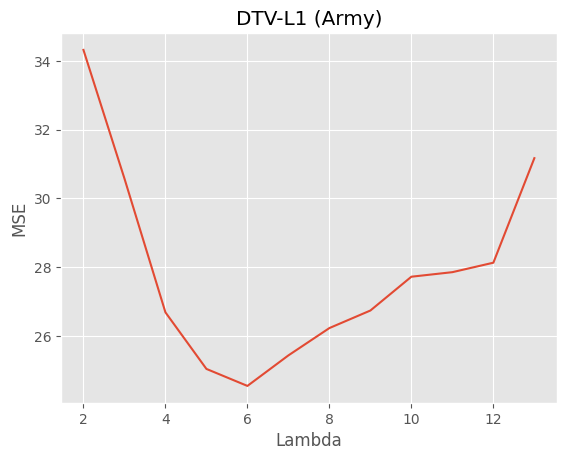

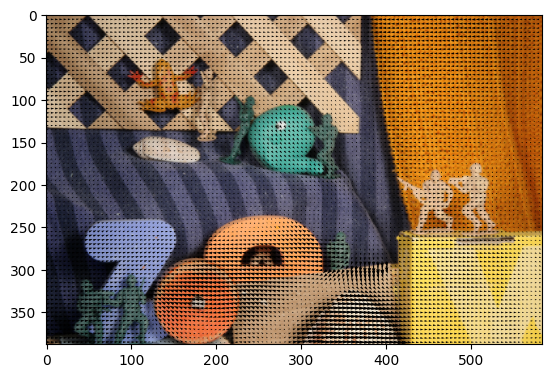

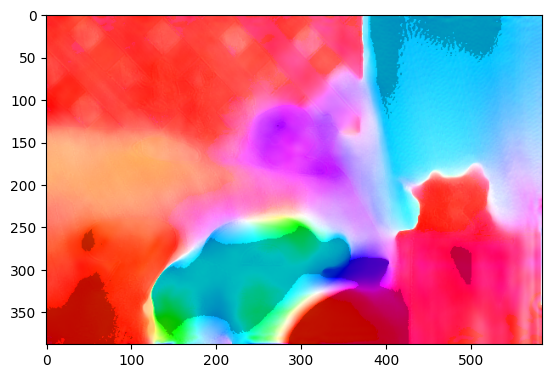

Lambda:  6
Interpolation Error (MSE):  24.548664


In [12]:
plot_dtvl1_result("Army", np.arange(2,14))

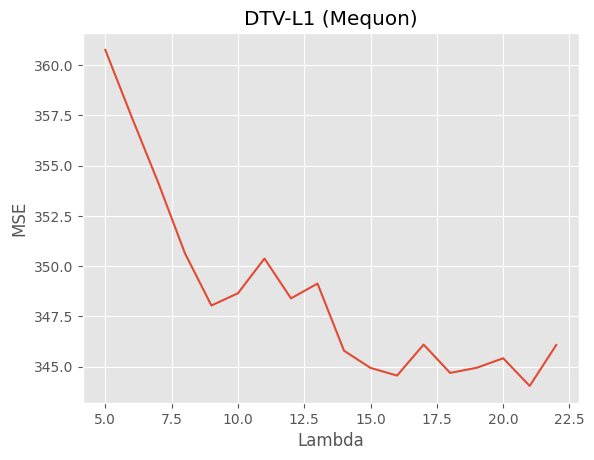

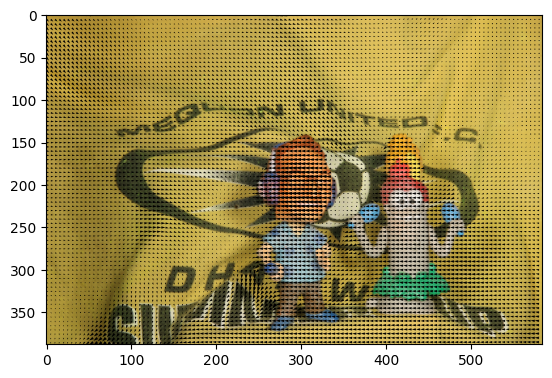

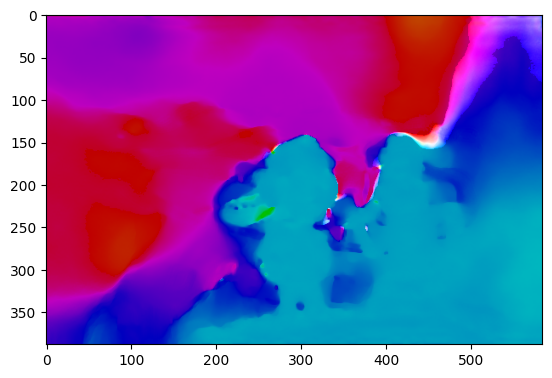

Lambda:  21
Interpolation Error (MSE):  344.04153


In [13]:
plot_dtvl1_result("Mequon", np.arange(5,23))

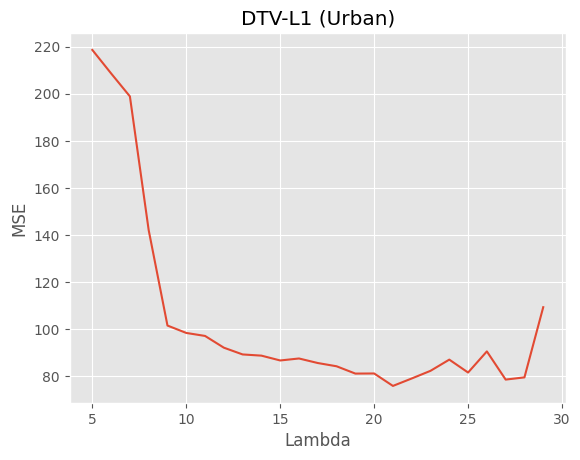

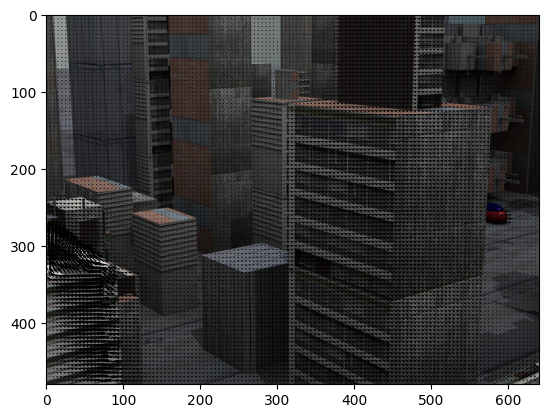

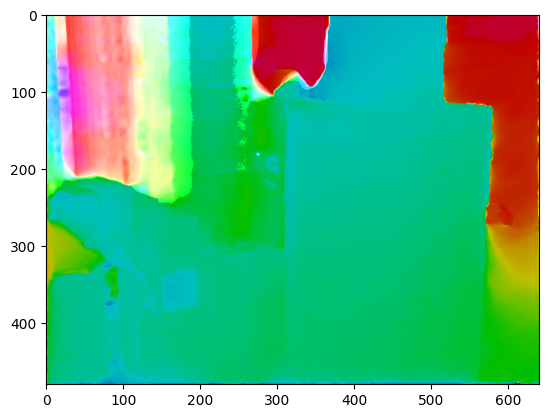

Lambda:  21
Interpolation Error (MSE):  75.73808


In [14]:
plot_dtvl1_result("Urban", np.arange(5,30))